# Task 2 - Runtime comparison

## R package runtime

In [1]:
#R packages used in task
library(stringr)
library(readr)
library(tidyverse)
library(stablemarriage)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
#Generates n x n preference tables and runs and times the algorithm using the R package
check_times_R = function(n, runs){
  M = str_c("M",seq(n))
  f = M = str_c("f",seq(n))
  
  times = 0
  
  for (i in 1:runs) {
    M_tab = random_pref_table(M,f)
    F_tab = random_pref_table(f,M)    
    
    times = times + system.time(find_stable_marriages(M_tab,F_tab,"U"))["elapsed"] 
    
  }
  return(times/runs)
}

In [3]:
if (file.exists("R implementation times2.csv")){
  Times_R = read.csv("R implementation times2.csv")
  
}else{
  
  set.seed(111111)
  sizes = c(1:20,seq(22,50,2),seq(55,100,5),seq(110,250,10))
  Times = c()
  for (n in sizes){
    Times = c(Times, check_times_R(n,50))
    message("Size ",n,appendLF = F)
  }
  
  Times_R = data.frame(n = sizes, time = Times)
  write_csv(Times_R,"R implementation times2.csv")
  
}

Size 1
Size 2
Size 3
Size 4
Size 5
Size 6
Size 7
Size 8
Size 9
Size 10
Size 11
Size 12
Size 13
Size 14
Size 15
Size 16
Size 17
Size 18
Size 19
Size 20
Size 22
Size 24
Size 26
Size 28
Size 30
Size 32
Size 34
Size 36
Size 38
Size 40
Size 42
Size 44
Size 46
Size 48
Size 50
Size 55
Size 60
Size 65
Size 70
Size 75
Size 80
Size 85
Size 90
Size 95
Size 100
Size 110
Size 120
Size 130
Size 140
Size 150
Size 160
Size 170
Size 180
Size 190
Size 200
Size 210
Size 220
Size 230
Size 240
Size 250


## Python Implementation

Code copied from Python Programming assignment. Analysis was redone on the Linux virtual machine instead of using the times saved from the Python assessment so that the difference in run times cannot be partially attributed to computing power.

In [4]:
#Python libraries used in this task

import random
import pandas as pd

import bidict as bd
import copy

import time
from os import listdir
import numpy as np
import csv

In [5]:
def create_pref_tables(males, females):
    """
    Input: two lists of distinct and mutually disjoint symbols of equal length
    Randomly generates a prefence list for each male and female in the given lists
    Output: two random preference tables (dictionaries with string keys and list values)
    """
    
    #partial check for valid input
    if len(males) != len(females):
        return 
    
    N = len(males) 
    
    #male preference table
    male_prefs = dict()
    for m in males:
        male_prefs[m] = random.sample(females,N)
    
    #create female preference table
    female_prefs = dict()
    for f in females:
        female_prefs[f] = random.sample(males,N)
    
    return male_prefs, female_prefs
    

    
def pref_to_rank_table(pref_table,options):
    """
    Input: preference table (dictionary) and the list of keys for the opposite gender
    
    Rows are keys from pref_table, columns are values from the list options
    Assigns a score for each preference: 1 is the lowest score, N is the rank of the most desirable
    
    Output: rank table (dataframe) 
    """    
    
    N = len(options)
    ranks = dict()
    for p, prefs in pref_table.items():        
        ranks[p] = [N - prefs.index(options[i]) for i in range(N)] #calculating score from index of preference
    
    return pd.DataFrame.from_dict(ranks, orient='index', columns = options)


def find_stable_marriages(male_pref, female_pref, U):
    """
    Input: 2 preference tables (dictionary), string for undesirable male
    Uses preference tables and runs the Fundamental Algorithm to find a stable marriage
    Output: a stable marriage (bidict with key males and values female partner)
    """
    
    M = list(male_pref.keys())
    k = 0
    n = len(M)
    matchings = dict(zip(female_pref.keys(),[U]*n)) #initial matching with keys females and value undesirable male
    
    #updating female rank table to include undesirable male
    F_rank = pref_to_rank_table(female_pref,M)
    F_rank[U] = [0]*n
    
    M_working = copy.deepcopy(male_pref) #copy to not change original input
    
    while k<n:
        X = M[k]
        while X != U:
            x = M_working[X][0] #not pop because we remove it after changing X
            
            #update female's partner if better than current partner
            if F_rank.at[x,X] > F_rank.at[x,matchings[x]]:
                X, matchings[x] = matchings[x], X
                
            if X != U: #X is female's previous partner
                M_working[X].remove(x) 
        k += 1

    #final matchings as bidict with male as keys
    
    return bd.bidict(matchings).inverse     


In [6]:
def check_times(n,runs):
    """Generates n x n preference tables and runs and times the algorithm"""
    
    M = ['M'+str(i) for i in range(n)]
    f = ['f'+str(i) for i in range(n)]

    times = 0

    for i in range(runs) :
        M_tab, F_tab = create_pref_tables(M,f)

        start = time.perf_counter()
        match = find_stable_marriages(M_tab,F_tab,"U") 
        end = time.perf_counter()   
        times += end-start
        
    return times/runs #average time per run

    

In [7]:
#to load times already saved
fileName = "Python implementation times2.csv"
if fileName in listdir(): 
    Times_Python = pd.read_csv(r"Python implementation times2.csv")

else:
    #to actually run the code for different sized tables
    random.seed(1000)
    Times = dict()
    sizes = list(range(1,21)) + list(range(22, 50,2)) + list(range(50,100,5)) + list(range(100,251,10))
    for n in sizes:
        Times[n] = check_times(n,50)
        print ("Size ",n, end="\r")
        
    #to save the output
    Times_Python = pd.DataFrame(Times.items(), columns=['n', 'time'])
    Times_Python.to_csv(r"Python implementation times2.csv")
    

## Comparison of Implementations
In comparing the implementations, I ran both versions in the same Jupyter notebook to ensure that the environment is not a factor is the run times. Important to note is that although the same data size is being used, due to different random number generators (and seeds) used for Python and R, the data used is not the same between implementations and may contribute to the differences.

New names:
* `` -> ...1



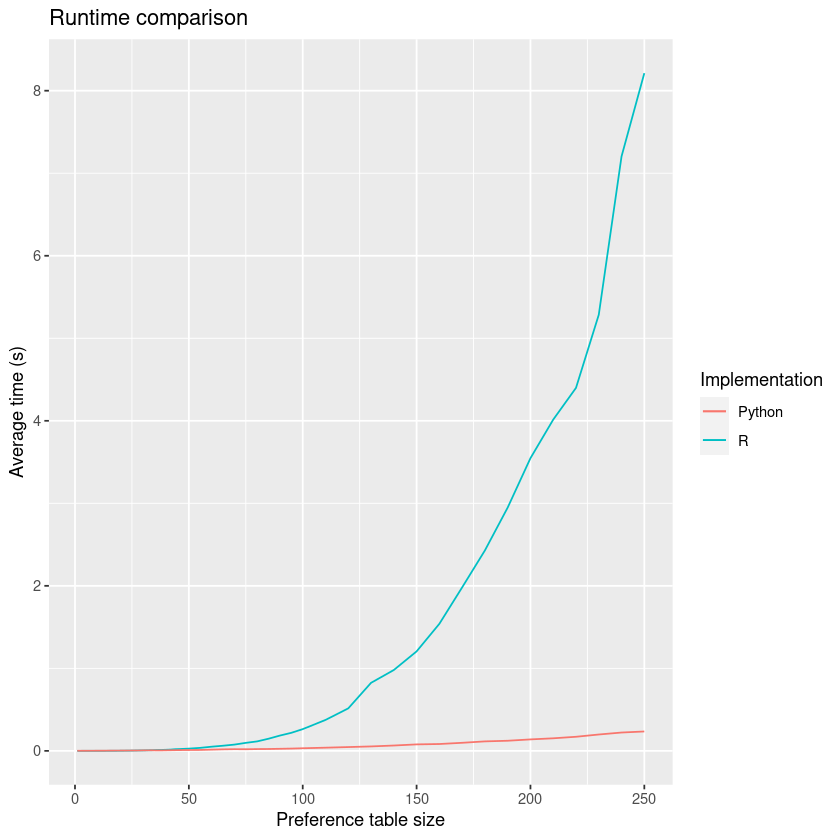

In [8]:
Times_R = read_csv("R implementation times2.csv", show_col_types = FALSE)
Times_Python = read_csv("Python implementation times2.csv", col_types = cols(...1 = col_skip()))

ggplot() +
  geom_line(aes(x = n, y = time, colour = "R"), data = Times_R) +
  geom_line(aes(x = n, y = time, colour = "Python"), data = Times_Python) +
  labs(x = "Preference table size" , y = "Average time (s)", title = "Runtime comparison", colour = "Implementation") 
  


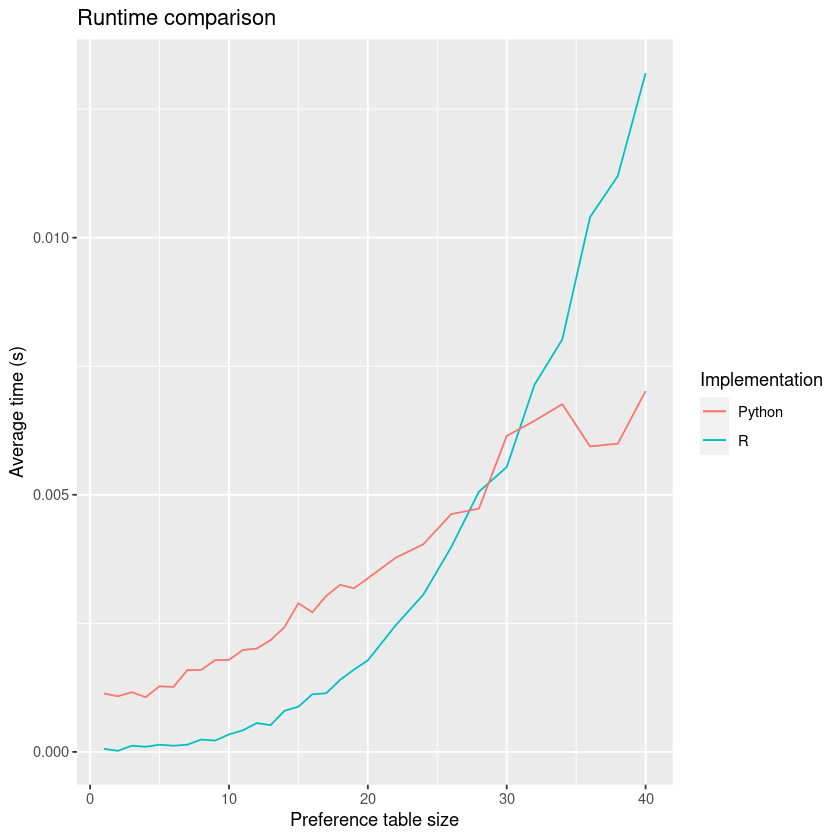

In [12]:
# smaller preference tables
ggplot() +
  geom_line(aes(x = n, y = time, colour = "R"), data = Times_R[1:30,]) +
  geom_line(aes(x = n, y = time, colour = "Python"), data = Times_Python[1:30,]) +
  labs(x = "Preference table size" , y = "Average time (s)", title = "Runtime comparison", colour = "Implementation") 
  

As the plot above shows, the R implementation is more efficient for smaller preference tables. The R implementation increases much more drastically with size than the Python implementation, so for larger preference tables (around $n>30$), the Python implementation is more efficient. This is likely because of the data structures used in R and the wrapper functions needed to convert them to the C++ data types. 